# I- Contexte

Vous êtes consultant Data Analyst dans une entreprise spécialisée dans la data. Votre entreprise a décroché une [prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM).  
<img src="img/logo_oncfm.png" style="display: block; margin-left: auto; margin-right: auto; width: 100%;"/>   
Cette institution a pour objectif de [mettre en place des méthodes d’identification des contrefaçons des billets en euros. Ils font donc appel à vous, spécialiste de la data, pour mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent.  
Voici le cahier des charges de l’ONCFM [cahier des charges](doc/cahier_des_charges.pdf) ainsi que le jeu de données [billets.csv](data_raw/billets.csv)  
Le client souhaite que vous travailliez directement depuis ses locaux sous la responsabilité de Marie, responsable du projet d’analyse de données à l’ONCFM.  
Elle vous laissera une grande autonomie pendant votre mission, et vous demande simplement que vous lui présentiez vos résultats une fois la mission terminée.   
Elle souhaite voir quels sont les traitements et analyses que vous avez réalisés en amont, les différentes pistes explorées pour la construction de l’algorithme, ainsi que le modèle final retenu.

Après avoir lu en détail le cahier des charges, vous vous préparez à vous rendre à l’ONCFM pour prendre vos nouvelles fonctions. Vous notez tout de même un post-it qui se trouve sur le coin de votre bureau, laissé par un de vos collègues :

In [18]:
# je commence par importer les bibliothèques dont j'aurai besoin dans mon analyse
import pandas as pd
import matplotlib.pyplot as plt

# II- Importation des fichiers

In [4]:
# Lecture du fichier avec ; comme séparateur
data = pd.read_csv("data_raw/billets.csv", sep=';')

# Affiche les 5 premières lignes
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


III- Résumé des datas

In [7]:
# On affiche le type de variables, le nombre de valeur pour chacune
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [5]:
# On affiche un résumé des datas notamment avec le nombre de valeurs uniques pour la colonne type bool
data.describe(include="all")

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


Nous avons un dataframe composé de 7 colonnes et 1 500 lignes  
1 colonne de type boléenne avec 1 000 "True" et 500 "False"  
6 colonnes de type float  
la colonne margin_low ne contient que 14 63 valeurs

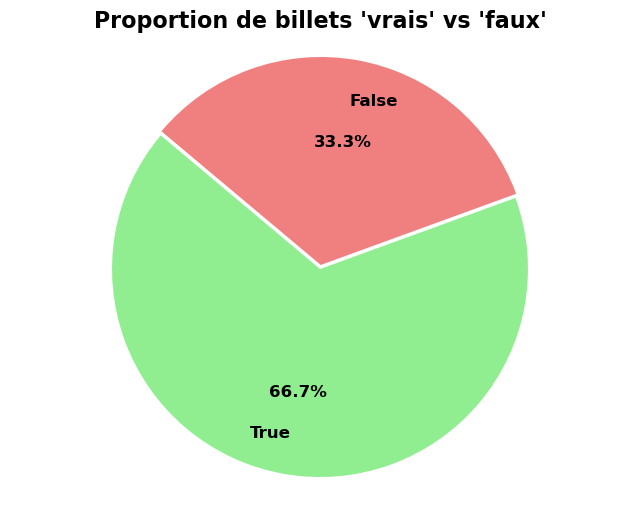

In [44]:
plt.figure(figsize=(8, 6))
counts = data["is_genuine"].value_counts() # compte le nombre de valeurs unique dans la colonne 'is_genuine'
plt.pie(
    counts, # données utilisées pour le pie
    labels=counts.index, # label 'true' ou 'false'
    colors=["lightgreen", "lightcoral"], # couleurs sympa ;-)
    autopct="%1.1f%%", # affiche les pourcentage
    startangle=140, # angle de départ
    explode=(0, 0.02), # Exagération d'une tranche
    labeldistance=0.8, # Distance des labels par rapport au centre
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'}  # Propriétés de la police des labels
)
plt.axis("equal")
plt.title("Proportion de billets 'vrais' vs 'faux'", fontsize=16, fontweight='bold', color='black', loc='center')
plt.show()

Je vais stocker les lignes pour lesquelles la colonne margin_low est vide

In [14]:
# création d'un sous dataframe avec uniquement les lignes ou margin_low est vide "NaN"
missing_margin_low = data[data["margin_low"].isna()]

In [17]:
# compte le nombre de ligne de ce sous dataframe
print("il y a ", len(missing_margin_low), "lignes pour lesquelles 'margin_low' est 'NaN'")

il y a  37 lignes pour lesquelles 'margin_low' est 'NaN'


In [100]:
# Imprimer un résumé des dimensions du DataFrame
print("En résumé, nous avons un DataFrame composé :\n",
      f"- de {data.shape[0]} lignes\n",  # Nombre de lignes
      f"- de {data.shape[1]} colonnes\n",  # Nombre de colonnes
      f"- des colonnes : {data.columns.tolist()}\n"  # Liste des noms des colonnes
     )

# Afficher le nombre de types de variables uniques et leur liste
print(f"Il y a {len(data.dtypes.unique())} types de variables : {data.dtypes.unique()}\n")

# Lister les types de données et les colonnes correspondantes
types_uniques = data.dtypes.unique()  # Récupérer les types de données uniques dans le DataFrame
for type_variable in types_uniques:
    # Filtrer les colonnes correspondant à chaque type de données
    colonnes_par_type = data.columns[data.dtypes == type_variable].tolist()
    
    # Afficher le type de données et les colonnes associées
    print(f"La ou les colonnes de type {type_variable} sont : {', '.join(colonnes_par_type)}\n")

# Lister les colonnes contenant des valeurs NaN
colonnes_avec_nan = data.columns[data.isna().any()].tolist()  # Récupérer les colonnes avec des NaN
for miss_val_col in colonnes_avec_nan:
    # Compter le nombre de valeurs manquantes dans la colonne en cours
    miss_val_numb = data[miss_val_col].isna().sum()  
    
    # Afficher le résultat pour la colonne actuelle
    print(f"Dans la colonne '{miss_val_col}', il manque {miss_val_numb} valeurs.\n\n")

En résumé, nous avons un DataFrame composé :
 - de 1500 lignes
 - de 7 colonnes
 - des colonnes : ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

Il y a 2 types de variables : [dtype('bool') dtype('float64')]

La ou les colonnes de type bool sont : is_genuine

La ou les colonnes de type float64 sont : diagonal, height_left, height_right, margin_low, margin_up, length

Dans la colonne 'margin_low', il manque 37 valeurs.




Commençons par observer la moyenne de chaque colonne en fonction de la valeur de "is_genuine" "True" ou "False"

In [98]:
colonnes_numeriques = data.select_dtypes(include=['number']).columns.tolist() #récupérer les colonnes numériques
for num_col in colonnes_numeriques:
    true_mean_col = data[data['is_genuine']][num_col].mean() # calcul la moyenne des colonnes pour is_genuine True
    false_mean_col = data[~data['is_genuine']][num_col].mean() # calcul la moyenne des colonnes pour is_genuine False
    print(f"La moyenne de la colonne '{num_col}' pour les valeurs 'True' est : {true_mean_col:.2f}")
    print(f"La moyenne de la colonne '{num_col}' pour les valeurs 'False' est : {false_mean_col:.2f}")

La moyenne de la colonne 'diagonal' pour les valeurs 'True' est : 171.99
La moyenne de la colonne 'diagonal' pour les valeurs 'False' est : 171.90
La moyenne de la colonne 'height_left' pour les valeurs 'True' est : 103.95
La moyenne de la colonne 'height_left' pour les valeurs 'False' est : 104.19
La moyenne de la colonne 'height_right' pour les valeurs 'True' est : 103.81
La moyenne de la colonne 'height_right' pour les valeurs 'False' est : 104.14
La moyenne de la colonne 'margin_low' pour les valeurs 'True' est : 4.12
La moyenne de la colonne 'margin_low' pour les valeurs 'False' est : 5.22
La moyenne de la colonne 'margin_up' pour les valeurs 'True' est : 3.05
La moyenne de la colonne 'margin_up' pour les valeurs 'False' est : 3.35
La moyenne de la colonne 'length' pour les valeurs 'True' est : 113.20
La moyenne de la colonne 'length' pour les valeurs 'False' est : 111.63


Ou sous forme de dataframe pour plus de clarté

In [103]:
resultats = data.groupby("is_genuine").agg(lambda x: x.mean(skipna=True)
                                           if x.dtype in ["float64", "int64"]
                                           else None)
resultats.round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90,104.19,104.14,5.22,3.35,111.63
True,171.99,103.95,103.81,4.12,3.05,113.20
